In [55]:
# try to train CNN to classify different stages
# coding: utf-8

import numpy as np
import pandas as pd
import time, os, sys, glob, io
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns

mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 22})

import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold

In [3]:
now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
RANDOM_SEED = 42
PATH = os.path.join(os.getcwd(), "logs")
if not os.path.exists(PATH):
    os.makedirs(PATH)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
LOGFILE = os.path.join(PATH, now + '_training.txt')

# Logging

header = []

# header.append('Current Time: %s' % now)
header.append('PyTorch Version: %s' % torch.__version__)
header.append('CUDA device available: %s' % torch.cuda.is_available())
header.append('Using CUDA device: %s' % device)
header.append('Random Seed: %s' % RANDOM_SEED)
header.append('Output Path: %s' % PATH)


with open(LOGFILE, 'w') as f:
    for entry in header:
        print(entry)
        f.write('%s\n' % entry)
        f.flush()

PyTorch Version: 1.7.1
CUDA device available: True
Using CUDA device: cuda:0
Random Seed: 42
Output Path: C:\Users\AChub_Lab\Desktop\my_project\st_app\malaria-detection-classification\nbs\logs


In [5]:
def add2log(s):
    try:
        with io.open(LOGFILE, "a", encoding="utf-8") as f:
            f.write('%s\n' % s)
        print(s)
    except:
        print("not logged")

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    out = { 'train': { },  
            'valid': { }} 

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        s = 'Epoch {}/{}'.format(epoch, num_epochs - 1)
        add2log(s)
        add2log('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            # save stats
            out[phase][epoch] = [epoch_loss, epoch_acc.cpu().detach().numpy()]
            
            s = '{} Loss: {:.4f} | Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)
            add2log(s)

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


        print()

    time_elapsed = time.time() - since
    s = 'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)
    add2log(s)
 
    add2log('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, out

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



In [10]:
class MalariaDataset(Dataset):
    def __init__(self, data, transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_path,label = self.data[index]
        image = Image.open(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [11]:
# load data
path = r"C:\Users\AChub_Lab\Desktop\my_project\DMSO\DMSO\train"
matches = []
for root, dirnames, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith(('.png')) and "cp" not in filename:
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

class_name = {"uninf": 0, 'ring': 1, 'troph': 2, 'shiz': 3}
df_train = pd.DataFrame(matches, columns = ["img_path"])

df_train.loc[:, "stage"] = df_train["img_path"].str.split("\\", expand = True)[8]
df_train.loc[:, "label"] = df_train["stage"].map(class_name)
# create a list of the values we want to assign for each condition

# create a new column and use np.select to assign values to it using our lists as arguments
df_train.head()

df_train = df_train.dropna()
df_train.groupby("label").count()

3978


img_path  stage
label                 
0          1107   1107
1           828    828
2           857    857
3          1186   1186

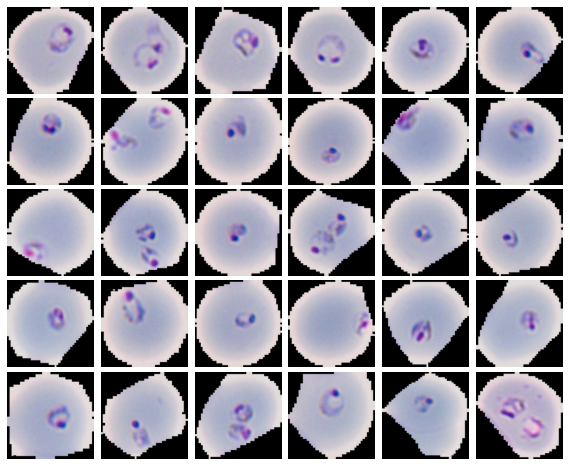

In [12]:
fig = plt.figure(figsize = (10,10))
gs1 = mpl.gridspec.GridSpec(6, 6)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

for idx, val in enumerate(df_train[df_train['label'] == 1]["img_path"][200:230]):
#     print (idx, val)
    ax = plt.subplot(gs1[idx])
    ax.axis("off")
    ax.set_aspect('equal')
    im = plt.imread(val)
    img_scaled = cv2.resize(im, (224, 224), interpolation = cv2.INTER_AREA)
    ax.imshow(img_scaled)

In [13]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 4

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
add2log(model_name)
add2log("Number of trainable params: " + str(count_parameters(model_ft)))
add2log(str(summary(model_ft)))

resnet
Number of trainable params: 2052
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  (36,864)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  (36,864)
|    |    └─BatchNorm2d: 3-5             (128)
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  (36,864)
|    |    └─BatchNorm2d: 3-7             (128)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (36,864)
|    |    └─BatchNorm2d: 3-10            (128)
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11       

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop((input_size, input_size), scale=(0.8, 1.0)),
        transforms.Resize((input_size, input_size)),
        torchvision.transforms.ColorJitter(brightness=0.1, contrast=.1, saturation=.1, hue=.4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(20, resample = Image.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((input_size, input_size)),
#         transforms.CenterCrop((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [15]:
batch_size = 32
train_data, valid_data = train_test_split(df_train[["img_path", "label"]], stratify=df_train["label"], test_size=0.2)
image_datasets =  { "train" : MalariaDataset(train_data, data_transforms["train"]), 
                     "valid": MalariaDataset(valid_data, data_transforms["valid"]) }
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

dataloaders = {"train": DataLoader(dataset = image_datasets["train"], batch_size = batch_size, shuffle=True, num_workers=0), 
              "valid": DataLoader(dataset = image_datasets["valid"], batch_size = batch_size, shuffle=False, num_workers=0)}

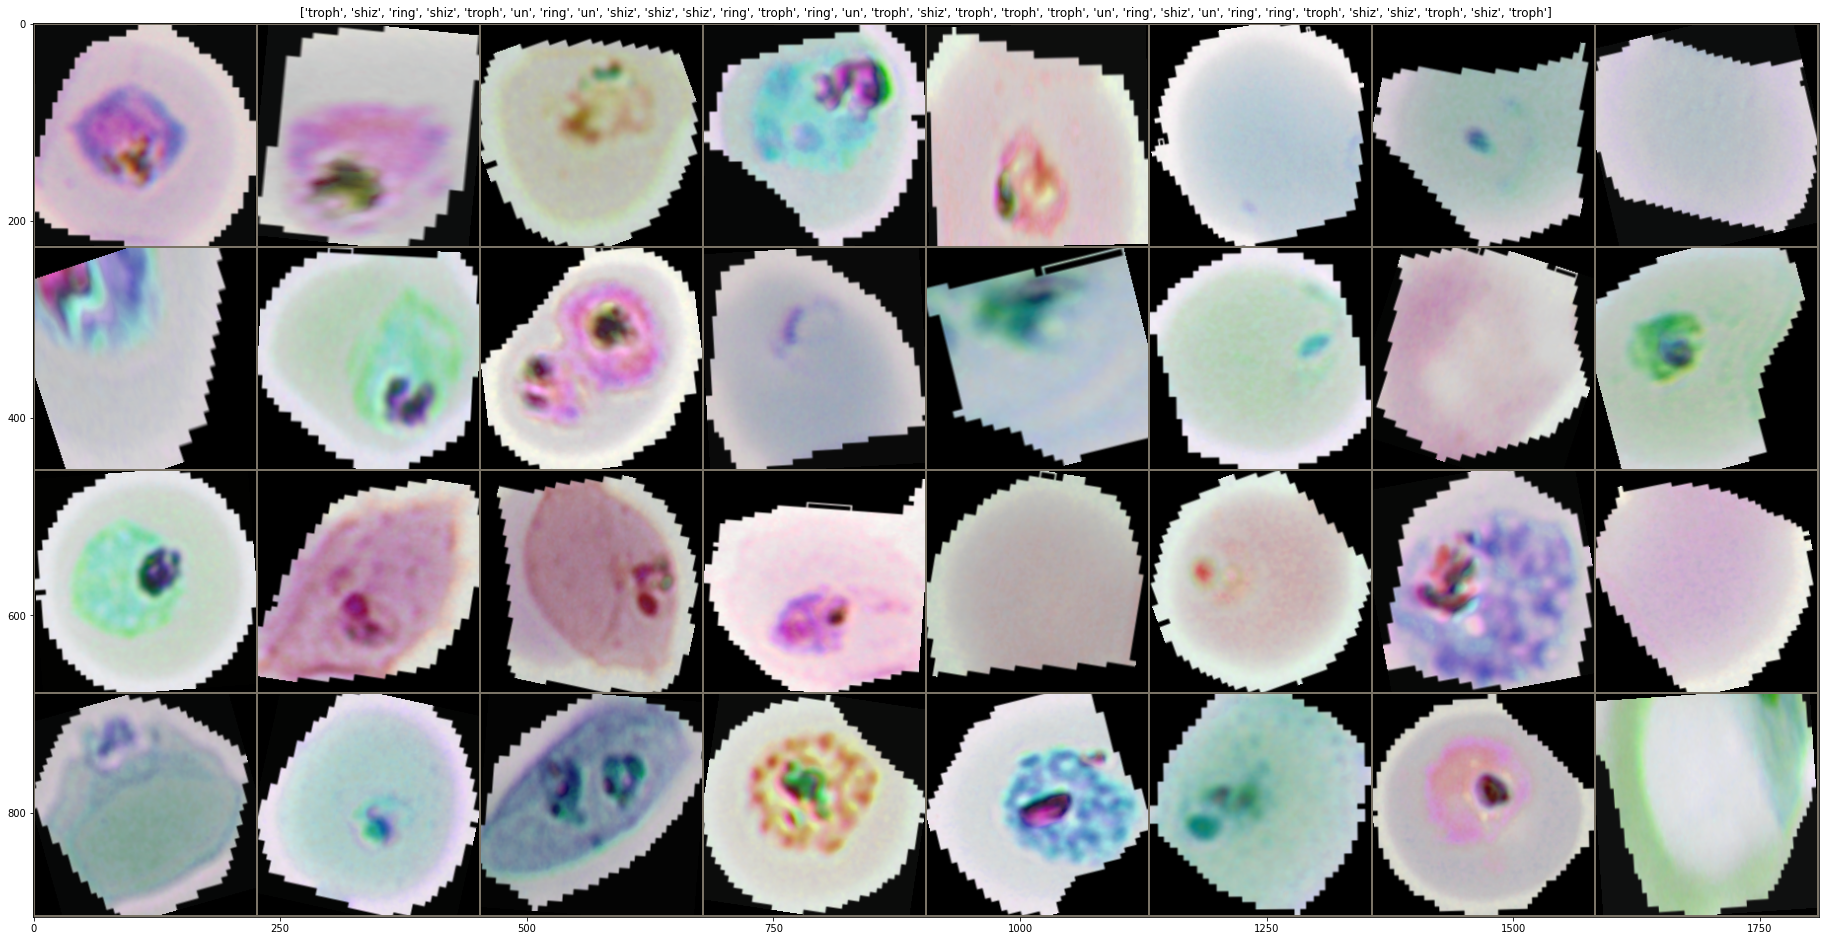

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

fig = plt.figure(figsize = (32, 32))
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))
class_name_ls = ["un", 'ring', 'troph', 'shiz']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_name_ls[x] for x in classes.int()])

In [21]:
add2log(data_transforms)

{'train': Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.4, 0.4])
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], resample=2, expand=False)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'valid': Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}


In [227]:
model_ft = model_ft.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()))
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()


In [229]:
# Train and evaluate
num_epochs = 30
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()))
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, 
                             num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/29
----------
train Loss: 0.6856 | Acc: 0.8004
valid Loss: 0.4554 | Acc: 0.8078

Epoch 1/29
----------
train Loss: 0.6963 | Acc: 0.7957
valid Loss: 0.4553 | Acc: 0.8216

Epoch 2/29
----------
train Loss: 0.6956 | Acc: 0.7850
valid Loss: 0.4544 | Acc: 0.8178

Epoch 3/29
----------
train Loss: 0.6900 | Acc: 0.7891
valid Loss: 0.5042 | Acc: 0.7990

Epoch 4/29
----------
train Loss: 0.7293 | Acc: 0.7841
valid Loss: 0.4863 | Acc: 0.8028

Epoch 5/29
----------
train Loss: 0.6613 | Acc: 0.8052
valid Loss: 0.4731 | Acc: 0.7952

Epoch 6/29
----------
train Loss: 0.7059 | Acc: 0.7794
valid Loss: 0.4474 | Acc: 0.8229

Epoch 7/29
----------
train Loss: 0.6576 | Acc: 0.8020
valid Loss: 0.4279 | Acc: 0.8216

Epoch 8/29
----------
train Loss: 0.6900 | Acc: 0.7819
valid Loss: 0.4347 | Acc: 0.8279

Epoch 9/29
----------
train Loss: 0.7112 | Acc: 0.7784
valid Loss: 0.4283 | Acc: 0.8329

Epoch 10/29
----------
train Loss: 0.6666 | Acc: 0.8030
valid Loss: 0.4578 | Acc: 0.8128

Epoch 11/29
--------

In [70]:
# Set fixed random number seed
k_folds = 5
dataset = df_train[["img_path", "label"]]

kfold = KFold(n_splits=k_folds, shuffle=True)
results = {}

# Number of classes in the dataset
num_classes = 4
# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for
num_epochs = 30
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True
models_ls = ["resnet", "vgg", "alexnet", "squeezenet", "densenet"]
results = {key: [] for key in models_ls} 

for m in models_ls[:]:
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    #     print (fold, len(train_ids) , len(test_ids))
        image_datasets = {}
        dataloaders = {}
        add2log(f'FOLD {fold}')
        add2log('*'*10)

        image_datasets =  { "train" : MalariaDataset(dataset.loc[train_ids], data_transforms["train"]), 
                             "valid": MalariaDataset(dataset.loc[test_ids], data_transforms["valid"]) }
        dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

        dataloaders = {"train": DataLoader(dataset = image_datasets["train"], batch_size = batch_size, shuffle=True, num_workers=0), 
                      "valid": DataLoader(dataset = image_datasets["valid"], batch_size = batch_size, shuffle=False, num_workers=0)}

        # Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
        model_name = m

        # Initialize the model for this run
        model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

        # Print the model we just instantiated
        add2log(model_name)
        add2log(f"Number of trainable params: {count_parameters(model_ft)}")
#         add2log(str(summary(model_ft)))

        model_ft = model_ft.to(device)

        # Observe that all parameters are being optimized
        optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()))
        # Decay LR by a factor of 0.1 every 7 epochs
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
        # Setup the loss fxn
        criterion = nn.CrossEntropyLoss()

        # Train and evaluate
        model_ft, out = train_model(model_ft, dataloaders, criterion, optimizer_ft, 
                                 num_epochs=num_epochs, is_inception=(model_name=="inception"))
        results[m].append(out)
        # Saving the model
        save_path = f'./{m}-fold-{fold}.pth'
        torch.save(model_ft.state_dict(), save_path)

FOLD 0
**********
resnet
Number of trainable params: 2052
Epoch 0/29
----------
train Loss: 0.9119 | Acc: 0.6405
valid Loss: 0.6750 | Acc: 0.7412

Epoch 1/29
----------
train Loss: 0.6577 | Acc: 0.7508
valid Loss: 0.5169 | Acc: 0.8254

Epoch 2/29
----------
train Loss: 0.5662 | Acc: 0.7825
valid Loss: 0.4780 | Acc: 0.8078

Epoch 3/29
----------
train Loss: 0.5281 | Acc: 0.8011
valid Loss: 0.4734 | Acc: 0.8090

Epoch 4/29
----------
train Loss: 0.5058 | Acc: 0.8102
valid Loss: 0.4315 | Acc: 0.8279

Epoch 5/29
----------
train Loss: 0.4831 | Acc: 0.8180
valid Loss: 0.4271 | Acc: 0.8342

Epoch 6/29
----------
train Loss: 0.4759 | Acc: 0.8193
valid Loss: 0.4086 | Acc: 0.8329

Epoch 7/29
----------
train Loss: 0.4672 | Acc: 0.8162
valid Loss: 0.4345 | Acc: 0.8178

Epoch 8/29
----------
train Loss: 0.4550 | Acc: 0.8265
valid Loss: 0.4026 | Acc: 0.8518

Epoch 9/29
----------
train Loss: 0.4557 | Acc: 0.8294
valid Loss: 0.3931 | Acc: 0.8568

Epoch 10/29
----------
train Loss: 0.4409 | Acc: 0.8

valid Loss: 0.3815 | Acc: 0.8480

Epoch 29/29
----------
train Loss: 0.3951 | Acc: 0.8488
valid Loss: 0.3840 | Acc: 0.8530

Training complete in 11m 45s
Best val Acc: 0.856784
FOLD 3
**********
resnet
Number of trainable params: 2052
Epoch 0/29
----------
train Loss: 0.9614 | Acc: 0.6107
valid Loss: 0.6780 | Acc: 0.7459

Epoch 1/29
----------
train Loss: 0.6239 | Acc: 0.7791
valid Loss: 0.5388 | Acc: 0.7899

Epoch 2/29
----------
train Loss: 0.5821 | Acc: 0.7820
valid Loss: 0.5120 | Acc: 0.8088

Epoch 3/29
----------
train Loss: 0.5197 | Acc: 0.8005
valid Loss: 0.4686 | Acc: 0.8264

Epoch 4/29
----------
train Loss: 0.4988 | Acc: 0.8074
valid Loss: 0.4790 | Acc: 0.8239

Epoch 5/29
----------
train Loss: 0.4846 | Acc: 0.8181
valid Loss: 0.4048 | Acc: 0.8528

Epoch 6/29
----------
train Loss: 0.4768 | Acc: 0.8228
valid Loss: 0.4014 | Acc: 0.8440

Epoch 7/29
----------
train Loss: 0.4566 | Acc: 0.8222
valid Loss: 0.4402 | Acc: 0.8314

Epoch 8/29
----------
train Loss: 0.4521 | Acc: 0.8241

valid Loss: 0.3701 | Acc: 0.8568

Epoch 27/29
----------
train Loss: 0.6154 | Acc: 0.7668
valid Loss: 0.3491 | Acc: 0.8555

Epoch 28/29
----------
train Loss: 0.6111 | Acc: 0.7678
valid Loss: 0.3879 | Acc: 0.8354

Epoch 29/29
----------
train Loss: 0.5938 | Acc: 0.7718
valid Loss: 0.3508 | Acc: 0.8656

Training complete in 13m 29s
Best val Acc: 0.870603
FOLD 1
**********
vgg
Number of trainable params: 16388
Epoch 0/29
----------
train Loss: 0.8310 | Acc: 0.6634
valid Loss: 0.5452 | Acc: 0.8015

Epoch 1/29
----------
train Loss: 0.6510 | Acc: 0.7392
valid Loss: 0.4736 | Acc: 0.8166

Epoch 2/29
----------
train Loss: 0.6287 | Acc: 0.7363
valid Loss: 0.4623 | Acc: 0.8178

Epoch 3/29
----------
train Loss: 0.5828 | Acc: 0.7674
valid Loss: 0.4610 | Acc: 0.8229

Epoch 4/29
----------
train Loss: 0.5955 | Acc: 0.7637
valid Loss: 0.4838 | Acc: 0.8015

Epoch 5/29
----------
train Loss: 0.5868 | Acc: 0.7668
valid Loss: 0.4472 | Acc: 0.8266

Epoch 6/29
----------
train Loss: 0.5887 | Acc: 0.7656

valid Loss: 0.5289 | Acc: 0.7786

Epoch 25/29
----------
train Loss: 0.5867 | Acc: 0.7769
valid Loss: 0.4386 | Acc: 0.8138

Epoch 26/29
----------
train Loss: 0.6052 | Acc: 0.7703
valid Loss: 0.4386 | Acc: 0.8176

Epoch 27/29
----------
train Loss: 0.5418 | Acc: 0.7839
valid Loss: 0.4305 | Acc: 0.8189

Epoch 28/29
----------
train Loss: 0.5786 | Acc: 0.7703
valid Loss: 0.4259 | Acc: 0.8226

Epoch 29/29
----------
train Loss: 0.5954 | Acc: 0.7656
valid Loss: 0.3975 | Acc: 0.8252

Training complete in 13m 52s
Best val Acc: 0.836478
FOLD 4
**********
vgg
Number of trainable params: 16388
Epoch 0/29
----------
train Loss: 0.8225 | Acc: 0.6598
valid Loss: 0.5560 | Acc: 0.7686

Epoch 1/29
----------
train Loss: 0.6761 | Acc: 0.7254
valid Loss: 0.5473 | Acc: 0.7786

Epoch 2/29
----------
train Loss: 0.6267 | Acc: 0.7477
valid Loss: 0.4954 | Acc: 0.7962

Epoch 3/29
----------
train Loss: 0.6034 | Acc: 0.7581
valid Loss: 0.4755 | Acc: 0.8038

Epoch 4/29
----------
train Loss: 0.5991 | Acc: 0.75

valid Loss: 0.6710 | Acc: 0.7035

Epoch 23/29
----------
train Loss: 0.6751 | Acc: 0.7310
valid Loss: 0.4522 | Acc: 0.8103

Epoch 24/29
----------
train Loss: 0.6653 | Acc: 0.7392
valid Loss: 0.5556 | Acc: 0.7601

Epoch 25/29
----------
train Loss: 0.6398 | Acc: 0.7483
valid Loss: 0.4483 | Acc: 0.8103

Epoch 26/29
----------
train Loss: 0.6544 | Acc: 0.7326
valid Loss: 0.4687 | Acc: 0.8015

Epoch 27/29
----------
train Loss: 0.6784 | Acc: 0.7253
valid Loss: 0.5311 | Acc: 0.7688

Epoch 28/29
----------
train Loss: 0.6792 | Acc: 0.7241
valid Loss: 0.5126 | Acc: 0.7764

Epoch 29/29
----------
train Loss: 0.6469 | Acc: 0.7502
valid Loss: 0.4777 | Acc: 0.8015

Training complete in 10m 58s
Best val Acc: 0.822864
FOLD 2
**********
alexnet
Number of trainable params: 16388
Epoch 0/29
----------
train Loss: 0.8845 | Acc: 0.6248
valid Loss: 0.6417 | Acc: 0.7161

Epoch 1/29
----------
train Loss: 0.7170 | Acc: 0.6967
valid Loss: 0.6233 | Acc: 0.7487

Epoch 2/29
----------
train Loss: 0.7229 | Acc

valid Loss: 0.4973 | Acc: 0.7925

Epoch 21/29
----------
train Loss: 0.6711 | Acc: 0.7301
valid Loss: 0.6442 | Acc: 0.7384

Epoch 22/29
----------
train Loss: 0.6979 | Acc: 0.7298
valid Loss: 0.5880 | Acc: 0.7396

Epoch 23/29
----------
train Loss: 0.7041 | Acc: 0.7282
valid Loss: 0.6791 | Acc: 0.7509

Epoch 24/29
----------
train Loss: 0.6677 | Acc: 0.7370
valid Loss: 0.5274 | Acc: 0.7887

Epoch 25/29
----------
train Loss: 0.6605 | Acc: 0.7301
valid Loss: 0.4501 | Acc: 0.8327

Epoch 26/29
----------
train Loss: 0.6978 | Acc: 0.7182
valid Loss: 0.4890 | Acc: 0.8013

Epoch 27/29
----------
train Loss: 0.6642 | Acc: 0.7342
valid Loss: 0.5887 | Acc: 0.7698

Epoch 28/29
----------
train Loss: 0.6683 | Acc: 0.7355
valid Loss: 0.5269 | Acc: 0.7836

Epoch 29/29
----------
train Loss: 0.6736 | Acc: 0.7333
valid Loss: 0.4636 | Acc: 0.8038

Training complete in 11m 4s
Best val Acc: 0.832704
FOLD 0
**********
squeezenet
Number of trainable params: 2052
Epoch 0/29
----------
train Loss: 0.8471 | 

train Loss: 0.2900 | Acc: 0.8947
valid Loss: 0.3157 | Acc: 0.8819

Epoch 19/29
----------
train Loss: 0.2922 | Acc: 0.8947
valid Loss: 0.3034 | Acc: 0.8932

Epoch 20/29
----------
train Loss: 0.3018 | Acc: 0.8891
valid Loss: 0.2970 | Acc: 0.9033

Epoch 21/29
----------
train Loss: 0.2836 | Acc: 0.8887
valid Loss: 0.3028 | Acc: 0.8945

Epoch 22/29
----------
train Loss: 0.3046 | Acc: 0.8850
valid Loss: 0.3091 | Acc: 0.8894

Epoch 23/29
----------
train Loss: 0.3139 | Acc: 0.8790
valid Loss: 0.3024 | Acc: 0.8982

Epoch 24/29
----------
train Loss: 0.2940 | Acc: 0.8897
valid Loss: 0.3240 | Acc: 0.8819

Epoch 25/29
----------
train Loss: 0.2896 | Acc: 0.8909
valid Loss: 0.3186 | Acc: 0.8970

Epoch 26/29
----------
train Loss: 0.2874 | Acc: 0.8966
valid Loss: 0.3132 | Acc: 0.8869

Epoch 27/29
----------
train Loss: 0.2910 | Acc: 0.8938
valid Loss: 0.2955 | Acc: 0.8920

Epoch 28/29
----------
train Loss: 0.2809 | Acc: 0.8957
valid Loss: 0.3161 | Acc: 0.8832

Epoch 29/29
----------
train Loss

train Loss: 0.3600 | Acc: 0.8649
valid Loss: 0.3705 | Acc: 0.8618

Epoch 17/29
----------
train Loss: 0.3568 | Acc: 0.8686
valid Loss: 0.3659 | Acc: 0.8656

Epoch 18/29
----------
train Loss: 0.3620 | Acc: 0.8608
valid Loss: 0.3497 | Acc: 0.8668

Epoch 19/29
----------
train Loss: 0.3687 | Acc: 0.8542
valid Loss: 0.4363 | Acc: 0.8304

Epoch 20/29
----------
train Loss: 0.3666 | Acc: 0.8554
valid Loss: 0.3444 | Acc: 0.8668

Epoch 21/29
----------
train Loss: 0.3686 | Acc: 0.8536
valid Loss: 0.3542 | Acc: 0.8618

Epoch 22/29
----------
train Loss: 0.3666 | Acc: 0.8589
valid Loss: 0.3462 | Acc: 0.8656

Epoch 23/29
----------
train Loss: 0.3671 | Acc: 0.8598
valid Loss: 0.3579 | Acc: 0.8668

Epoch 24/29
----------
train Loss: 0.3571 | Acc: 0.8661
valid Loss: 0.3490 | Acc: 0.8643

Epoch 25/29
----------
train Loss: 0.3295 | Acc: 0.8762
valid Loss: 0.3880 | Acc: 0.8455

Epoch 26/29
----------
train Loss: 0.3624 | Acc: 0.8652
valid Loss: 0.3502 | Acc: 0.8631

Epoch 27/29
----------
train Loss

train Loss: 0.3875 | Acc: 0.8530
valid Loss: 0.3471 | Acc: 0.8742

Epoch 15/29
----------
train Loss: 0.3662 | Acc: 0.8618
valid Loss: 0.3865 | Acc: 0.8415

Epoch 16/29
----------
train Loss: 0.3939 | Acc: 0.8495
valid Loss: 0.3766 | Acc: 0.8491

Epoch 17/29
----------
train Loss: 0.3681 | Acc: 0.8593
valid Loss: 0.3536 | Acc: 0.8667

Epoch 18/29
----------
train Loss: 0.3793 | Acc: 0.8555
valid Loss: 0.3765 | Acc: 0.8465

Epoch 19/29
----------
train Loss: 0.3578 | Acc: 0.8674
valid Loss: 0.3462 | Acc: 0.8679

Epoch 20/29
----------
train Loss: 0.3654 | Acc: 0.8646
valid Loss: 0.3442 | Acc: 0.8679

Epoch 21/29
----------
train Loss: 0.3887 | Acc: 0.8517
valid Loss: 0.3562 | Acc: 0.8528

Epoch 22/29
----------
train Loss: 0.3728 | Acc: 0.8571
valid Loss: 0.3855 | Acc: 0.8604

Epoch 23/29
----------
train Loss: 0.3826 | Acc: 0.8486
valid Loss: 0.3522 | Acc: 0.8579

Epoch 24/29
----------
train Loss: 0.3649 | Acc: 0.8523
valid Loss: 0.3299 | Acc: 0.8717

Epoch 25/29
----------
train Loss

In [71]:
df_results = pd.DataFrame.from_dict({(i,j, k): results[i][j][k] 
                           for i in results.keys() 
                           for j in range(len(results[i]))
                           for k in results[i][j].keys()
                           },
                       orient='index')
df_results = df_results.stack().reset_index()
df_results.columns = ["model", "fold", "phase", "epoch", "stat_ls"]
df_results.loc[:, "loss"] = df_results["stat_ls"].apply(lambda x: x[0])
df_results.loc[:, "acc"] = df_results["stat_ls"].apply(lambda x: x[1])
df_results.head()

model  fold  phase  epoch                                   stat_ls  \
0  resnet     0  train      0   [0.9118678326654704, 0.640477686989315]   
1  resnet     0  train      1   [0.657660381401357, 0.7507856693903205]   
2  resnet     0  train      2  [0.5661583540201337, 0.7825267127592709]   
3  resnet     0  train      3  [0.5281024177744282, 0.8010685103708359]   
4  resnet     0  train      4  [0.5057791423902506, 0.8101822752985544]   

       loss       acc  
0  0.911868  0.640478  
1  0.657660  0.750786  
2  0.566158  0.782527  
3  0.528102  0.801069  
4  0.505779  0.810182

In [73]:
results

{'resnet': [{'train': {0: [0.9118678326654704, array(0.64047769)],
    1: [0.657660381401357, array(0.75078567)],
    2: [0.5661583540201337, array(0.78252671)],
    3: [0.5281024177744282, array(0.80106851)],
    4: [0.5057791423902506, array(0.81018228)],
    5: [0.4831323799361679, array(0.81803897)],
    6: [0.47589435128203583, array(0.81929604)],
    7: [0.46721436910326564, array(0.81615336)],
    8: [0.455002468086353, array(0.8265242)],
    9: [0.45570139773307095, array(0.82935261)],
    10: [0.4408882998356199, array(0.82620993)],
    11: [0.4452877823172089, array(0.82935261)],
    12: [0.43714318142081116, array(0.827467)],
    13: [0.4261576541934202, array(0.82715273)],
    14: [0.42829592747931056, array(0.83029541)],
    15: [0.42555893894863306, array(0.83595223)],
    16: [0.4125453797171957, array(0.83815211)],
    17: [0.4199878885864387, array(0.82935261)],
    18: [0.41500574601363416, array(0.83406662)],
    19: [0.41908432207041607, array(0.83123821)],
    20: 

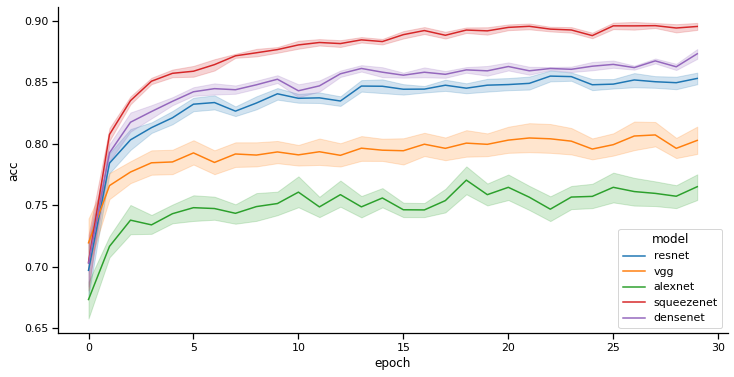

In [80]:
plt.rcParams.update({'font.size': 30})
plt.rcParams["figure.figsize"] = (12, 6)

sns.lineplot(data = df_results, x = "epoch", y = "acc", hue = "model", ci = 68)
sns.despine()

In [ ]:
pd.DataFrame.from_dict({(i,j): results[i][j] 
                           for i in results.keys() 
                           for j in results[i].keys()},
                       orient='index')

In [221]:
model_ft, input_size = initialize_model("inception", num_classes, feature_extract, use_pretrained=True)
model_ft.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [59]:
model_path = r"C:\Users\AChub_Lab\Desktop\my_project\Experiments\squeezenet-fold-0.pth"
model_ft.load_state_dict(torch.load(model_path))
model_ft.eval()
model_ft.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [216]:
# unfreeze top layers of convent
# note: firstly train head of the net
curr_layer = 0
layer_to_unfreeze = 45
for param in model_ft.parameters():
    curr_layer+=1
    if curr_layer >= layer_to_unfreeze:
        print (curr_layer, "child", param.shape)
#         continue
#         for param in child.parameters():
        param.requires_grad = True
        
#         add2log(child)


# add2log("Number of trainable params: " + str(count_parameters(model_ft)))

45 child torch.Size([64, 512, 1, 1])
46 child torch.Size([64])
47 child torch.Size([256, 64, 1, 1])
48 child torch.Size([256])
49 child torch.Size([256, 64, 3, 3])
50 child torch.Size([256])
51 child torch.Size([4, 512, 1, 1])
52 child torch.Size([4])


In [217]:
add2log("Number of trainable params: " + str(count_parameters(model_ft)))

Number of trainable params: 199236


In [222]:
num_epochs = 50
# model_ft.to(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr = 0.001)
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, 
                             num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [204]:
torch.save(model_ft.state_dict(), "squeezenet_model.pth")

In [212]:
summary(model_ft)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (14,208)
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Fire: 2-4                         --
|    |    └─Conv2d: 3-1                  (1,552)
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  (1,088)
|    |    └─ReLU: 3-4                    --
|    |    └─Conv2d: 3-5                  (9,280)
|    |    └─ReLU: 3-6                    --
|    └─Fire: 2-5                         --
|    |    └─Conv2d: 3-7                  (2,064)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (1,088)
|    |    └─ReLU: 3-10                   --
|    |    └─Conv2d: 3-11                 (9,280)
|    |    └─ReLU: 3-12                   --
|    └─Fire: 2-6                         --
|    |    └─Conv2d: 3-13                 (4,128)
|    |    └─ReLU: 3-14        

### Test the model

In [52]:
test_path = r"C:\Users\AChub_Lab\Desktop\my_project\cell_images\cell_images"
matches = []
for root, dirnames, filenames in os.walk(test_path):
    for filename in filenames:
        if filename.endswith(('.png', ".PNG")):
#             print (filename)
            matches.append(os.path.join(root, filename))
print (len(matches))

27545


In [53]:
df_test = pd.DataFrame(matches, columns = ["img_path"])
stage = df_test["img_path"].str.split("\\", expand = True)[7]
df_test.loc[:, "stage"] = stage

def add_label(row):
    if row['stage'] == "Parasitized":
        return 1
    if row['stage'] == 'Uninfected':
        return 0
    return 'Other'
df_test.loc[:, "label"] = df_test.apply (lambda row: add_label(row), axis=1)

df_test.head()

img_path        stage  label
0  C:\Users\AChub_Lab\Desktop\my_project\cell_ima...  Parasitized      1
1  C:\Users\AChub_Lab\Desktop\my_project\cell_ima...  Parasitized      1
2  C:\Users\AChub_Lab\Desktop\my_project\cell_ima...  Parasitized      1
3  C:\Users\AChub_Lab\Desktop\my_project\cell_ima...  Parasitized      1
4  C:\Users\AChub_Lab\Desktop\my_project\cell_ima...  Parasitized      1

In [54]:
df_test.groupby("label").count()

img_path  stage
label                 
0         13779  13779
1         13766  13766

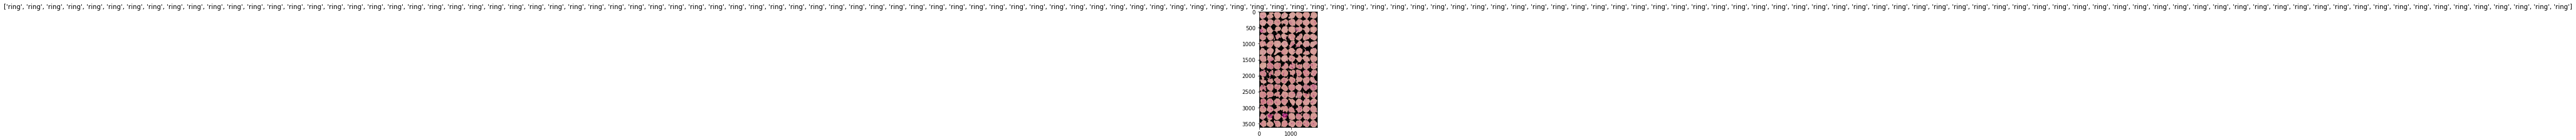

In [61]:
test_dataset =  MalariaDataset(df_test[["img_path", "label"]], data_transforms["valid"])
                     
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
batch_size = 128
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

inputs, classes = next(iter(test_loader))
class_names = ["un", 'ring', 'troph', 'shiz']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [207]:
# test-the-model
model = model_ft.eval()
all_preds = []
test_labels = []
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        predicted = predicted.cpu().numpy()
       
        labels = labels.cpu().numpy()
        all_preds.append(predicted)
        test_labels.append(labels)
        
        predicted_clip = np.clip(predicted, 0, 1)
        total += labels.size
        correct += (predicted_clip == labels).sum().item()
        
#         false_idx = ((predicted == labels) == 0).nonzero()
#         if len(false_idx) > 0:
#             print (predicted[false_idx].flatten())
#             print (labels[false_idx].flatten())
    s = 'Test Accuracy of the model: {:.4f} %'.format(100 * correct / total)
#     print (s)
    add2log(s)
# Save 
# torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 91.3705 %


In [65]:
plt.rcParams.update({'font.size': 22})

Text(0.5, 59.0, 'Predicted label')

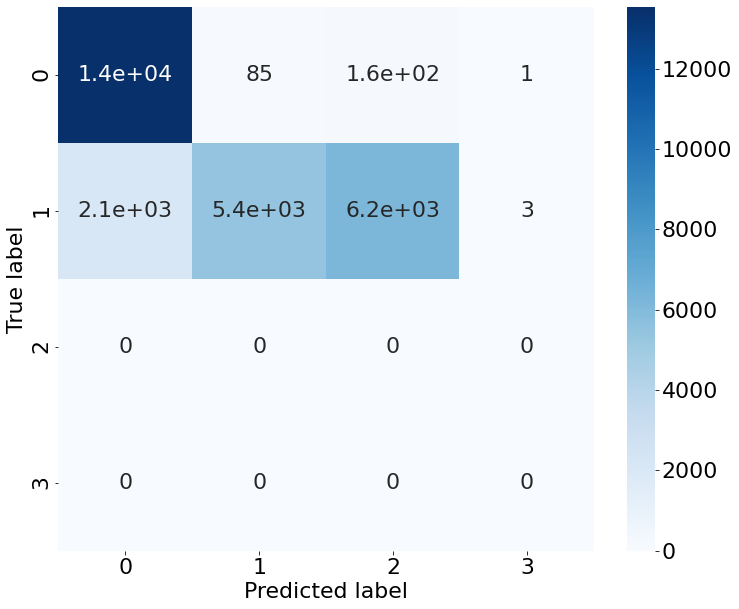

In [208]:
cm = confusion_matrix(np.concatenate(test_labels), np.concatenate(all_preds))
fig = plt.figure(figsize = (12,10))
sns.heatmap(cm, annot = True, cmap = "Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("confusion_matrix.png")

In [209]:
preds = np.concatenate(all_preds)
df_test.loc[:, "preds"] = preds

2131


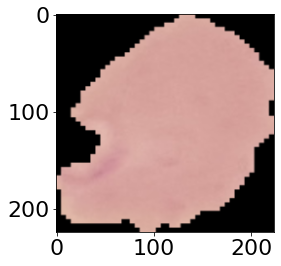

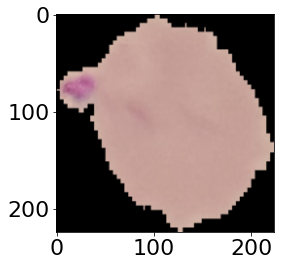

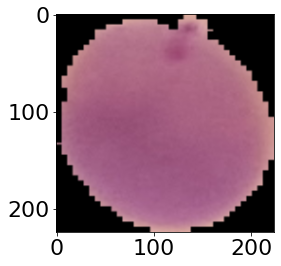

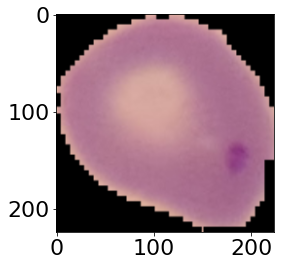

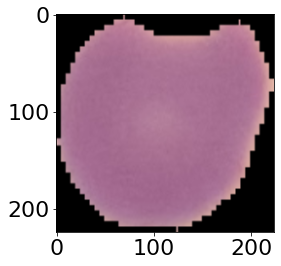

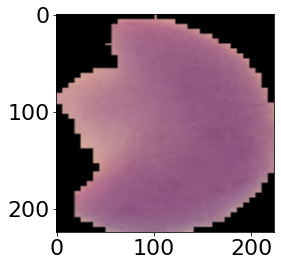

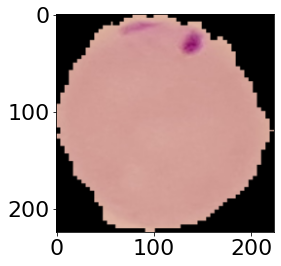

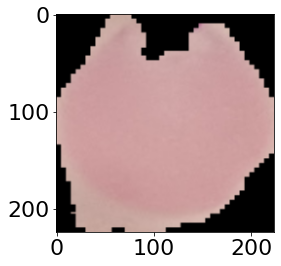

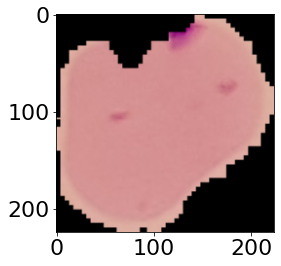

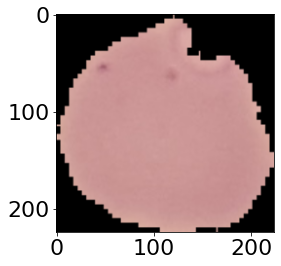

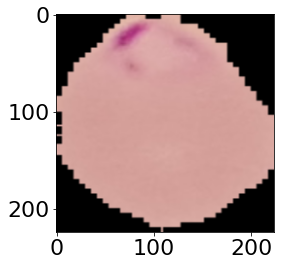

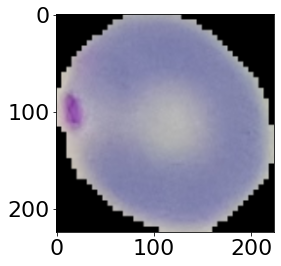

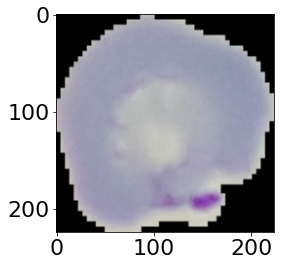

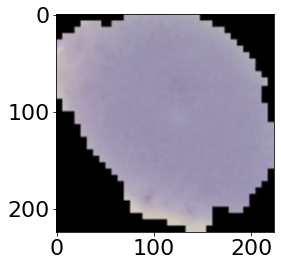

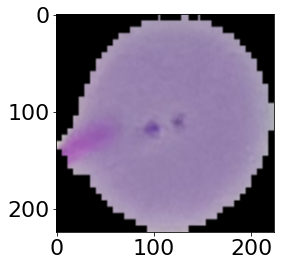

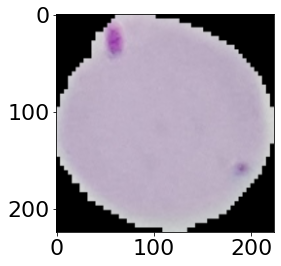

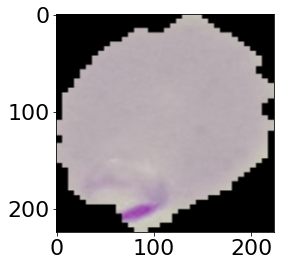

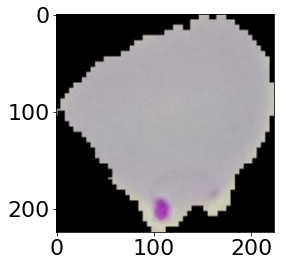

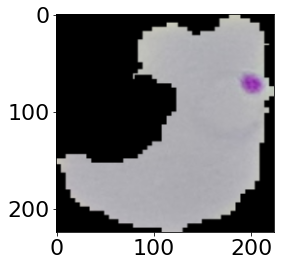

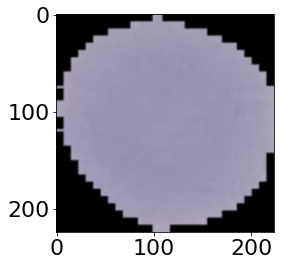

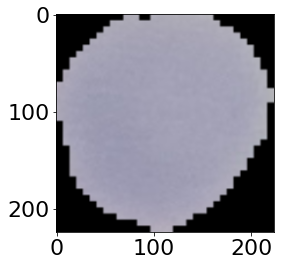

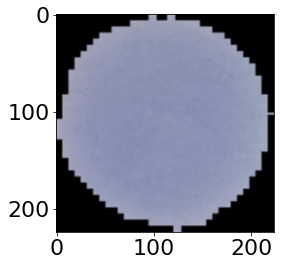

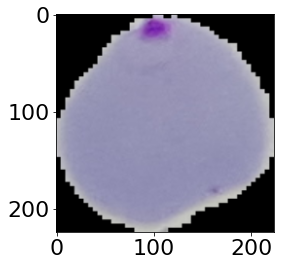

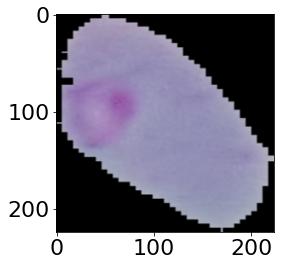

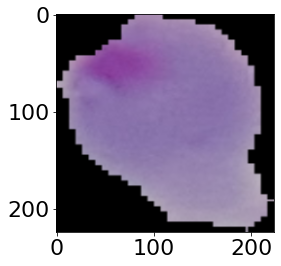

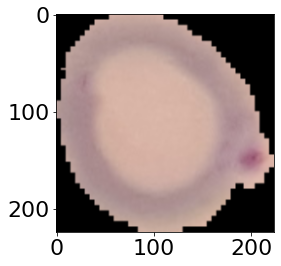

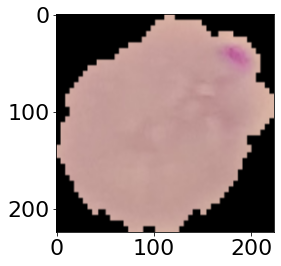

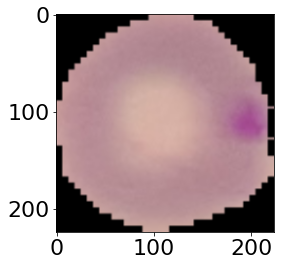

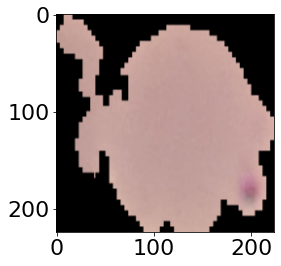

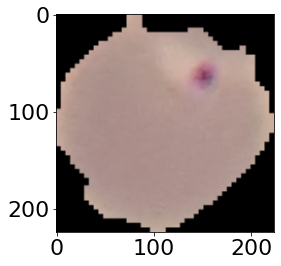

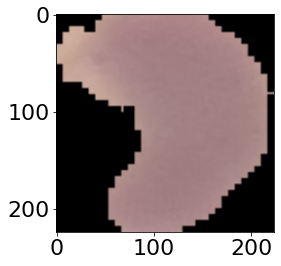

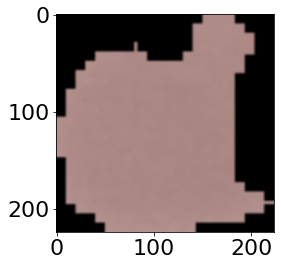

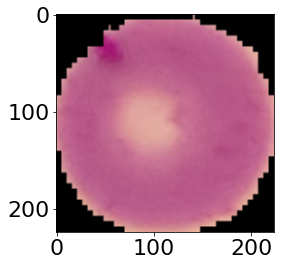

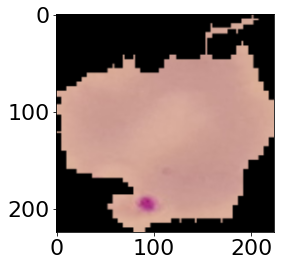

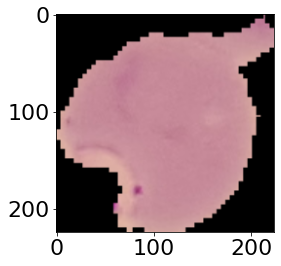

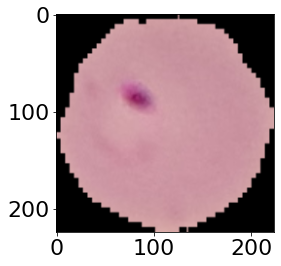

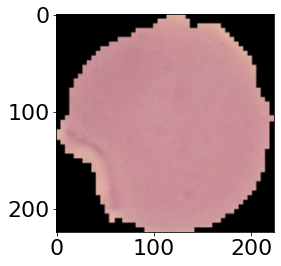

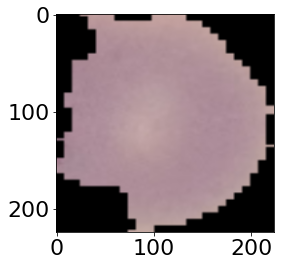

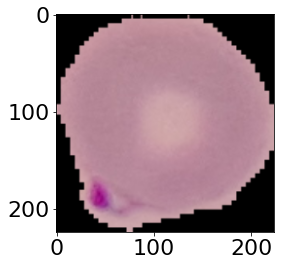

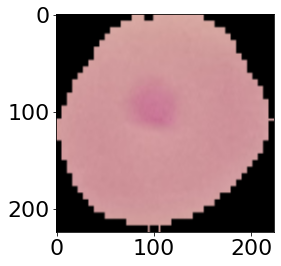

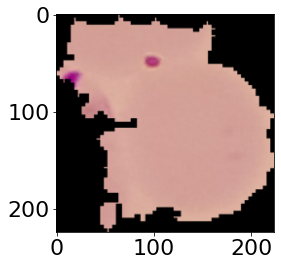

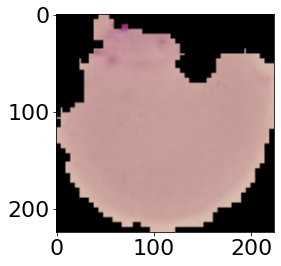

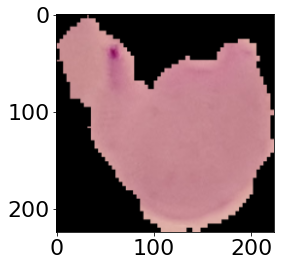

In [211]:
img_list = df_test[(df_test.preds == 0) & (df_test.label == 1)].img_path
print (len(img_list))
for fname in img_list[::50]:
    im = plt.imread(fname)
    im = cv2.resize(im, (224,224))
    plt.imshow(im)
    plt.show()
    